In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time
import dateutil.parser

from matplotlib import gridspec
import scipy.optimize as sciop
import json
from scipy.stats import mode

from lightkurve import search_targetpixelfile

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

from scipy.stats import binned_statistic

import corner

%matplotlib inline

In [2]:
kepStars = Table.read("./kepler_stellar_17.csv")

print(kepStars.colnames)
print(len(kepStars))

#eliminate any entries with NaNs
#also exclude giants, which (based on an HR diagram of the entire sample) we roughly define as stars with logg < 3.5
goodRows = ((kepStars['kepmag'].astype(float) > 0.) & (kepStars['dist'].astype(float) > 0.) & (kepStars['teff'].astype(float) > 0.) & (kepStars['feh'].astype(float) > -10.) & (kepStars['logg'].astype(float) > 3.5))

kepStars = kepStars[goodRows]

kepmag = np.array(kepStars['kepmag'])
dist = np.array(kepStars['dist'])
teff = np.array(kepStars['teff'])
feh = np.array(kepStars['feh'])
logg = np.array(kepStars['logg'])

cdpp3 = np.array(kepStars['rrmscdpp03p0'])
cdpp6 = np.array(kepStars['rrmscdpp06p0'])
cdpp12 = np.array(kepStars['rrmscdpp12p0'])

kepid = np.array(kepStars['kepid'])

['kepid', 'tm_designation', 'teff', 'teff_err1', 'teff_err2', 'logg', 'logg_err1', 'logg_err2', 'feh', 'feh_err1', 'feh_err2', 'mass', 'mass_err1', 'mass_err2', 'st_radius', 'radius_err1', 'radius_err2', 'dens', 'dens_err1', 'dens_err2', 'prov_sec', 'kepmag', 'dist', 'dist_err1', 'dist_err2', 'nconfp', 'nkoi', 'ntce', 'datalink_dvr', 'st_delivname', 'st_vet_date_str', 'degree_ra', 'degree_dec', 'st_quarters', 'teff_prov', 'logg_prov', 'feh_prov', 'jmag', 'jmag_err', 'hmag', 'hmag_err', 'kmag', 'kmag_err', 'dutycycle', 'dataspan', 'mesthres01p5', 'mesthres02p0', 'mesthres02p5', 'mesthres03p0', 'mesthres03p5', 'mesthres04p5', 'mesthres05p0', 'mesthres06p0', 'mesthres07p5', 'mesthres09p0', 'mesthres10p5', 'mesthres12p0', 'mesthres12p5', 'mesthres15p0', 'rrmscdpp01p5', 'rrmscdpp02p0', 'rrmscdpp02p5', 'rrmscdpp03p0', 'rrmscdpp03p5', 'rrmscdpp04p5', 'rrmscdpp05p0', 'rrmscdpp06p0', 'rrmscdpp07p5', 'rrmscdpp09p0', 'rrmscdpp10p5', 'rrmscdpp12p0', 'rrmscdpp12p5', 'rrmscdpp15p0', 'av', 'av_err1',

In [3]:
print(np.min(kepmag))
print(np.max(kepmag))
print(type(kepmag))

5.864
19.26
<class 'numpy.ndarray'>


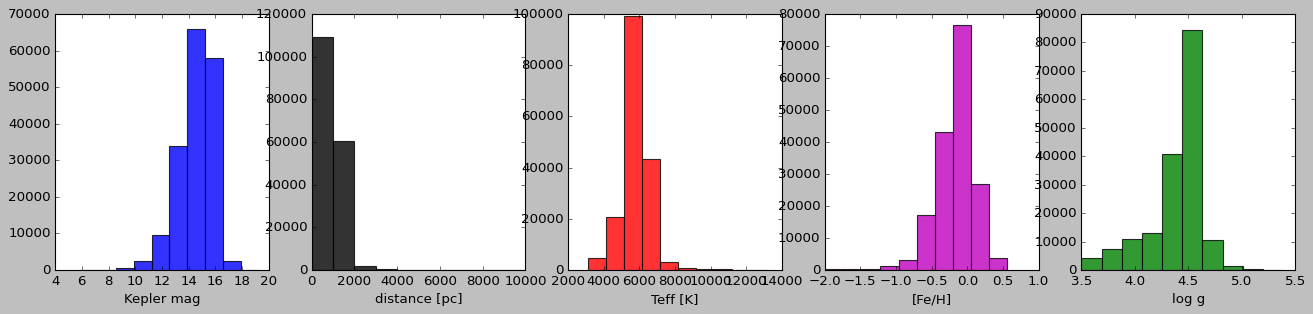

In [4]:
fig, axes = plt.subplots(1,5,figsize=(20,4))

axes[0].hist(kepmag,color='b',alpha=0.8)
axes[1].hist(dist,range=(0,10000),color='k',alpha=0.8)
axes[2].hist(teff,color='r',alpha=0.8)
axes[3].hist(feh,color='m',alpha=0.8)
axes[4].hist(logg,color='g',alpha=0.8)

axes[0].set_xlabel('Kepler mag')
axes[1].set_xlabel('distance [pc]')
axes[2].set_xlabel('Teff [K]')
axes[3].set_xlabel('[Fe/H]')
axes[4].set_xlabel('log g')

plt.show()

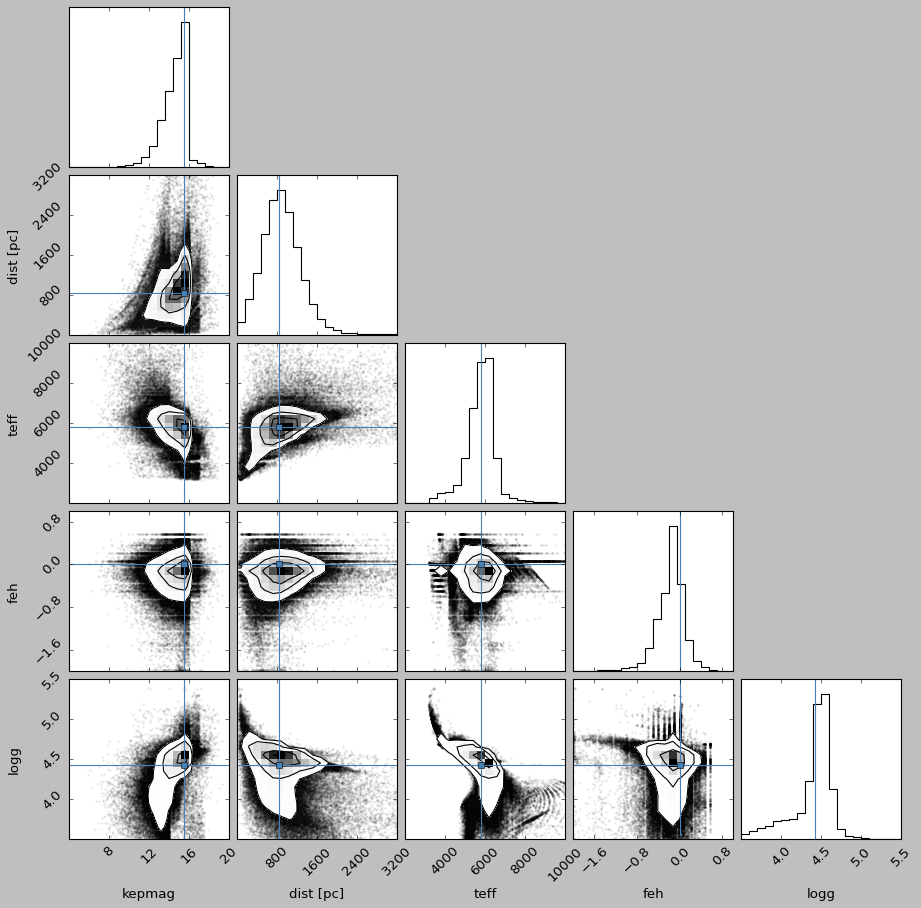

In [5]:
#truths = Solar values where applicable
#solar teff = 5780 K
#solar metallicity == 0
#solar logg (cm/s^2) = 4.43
fig = corner.corner(np.vstack((kepmag,dist,teff,feh,logg)).T,labels=['kepmag', 'dist [pc]','teff','feh','logg'],range=[(4,20),(0,3200),(2000,10000),(-2.0,1.0),(3.5,5.5)],truths=(15.5,850,5780,0,4.43))
plt.show()

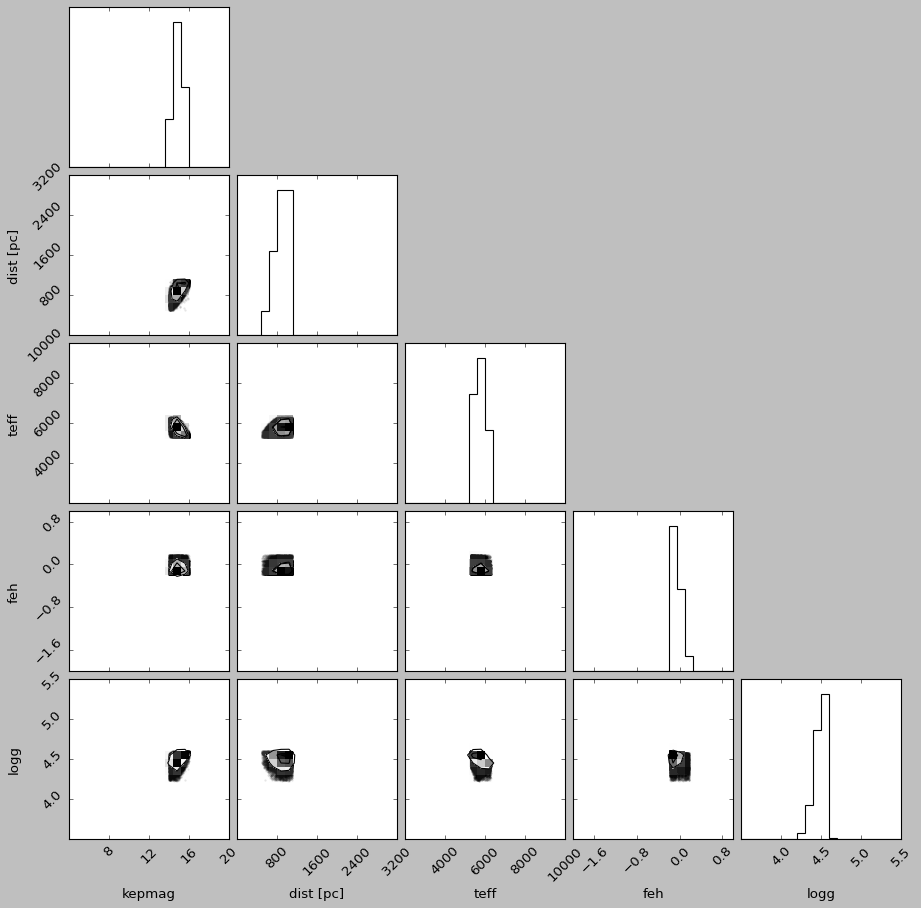

In [6]:
# make some cuts to get at the densest part of the distribution
peakMask = (kepmag > 14) & (kepmag < 16) & (dist > 500) & (dist < 1100) & (teff > 5280) & (teff < 6280) & (feh > -0.2) & (feh < 0.2) & (logg > 4.23) & (logg < 4.63)

fig = corner.corner(np.vstack((kepmag[peakMask],dist[peakMask],teff[peakMask],feh[peakMask],logg[peakMask])).T,labels=['kepmag', 'dist [pc]','teff','feh','logg'],range=[(4,20),(0,3200),(2000,10000),(-2.0,1.0),(3.5,5.5)])
plt.show()

In [7]:
print(len(kepmag))
print(len(kepmag[peakMask]))

172950
23812


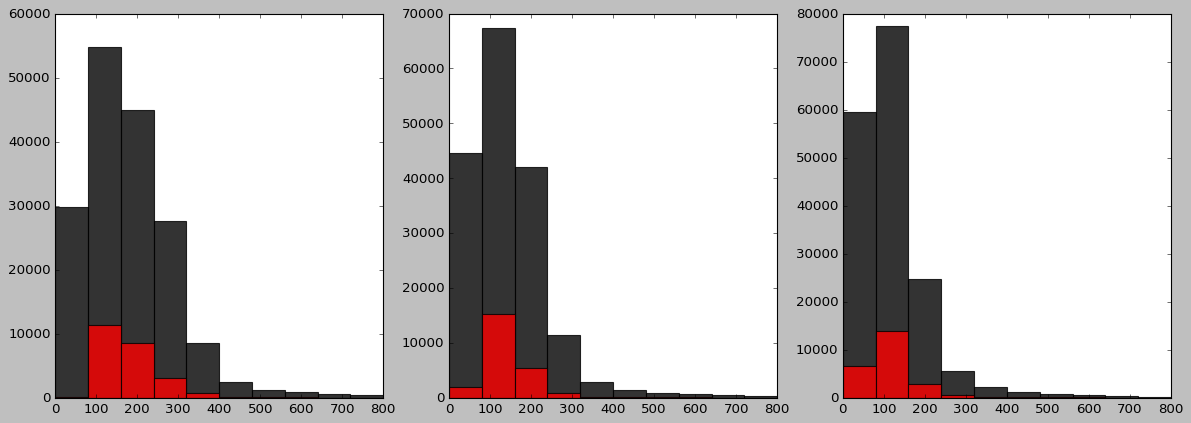

In [8]:
# so by considering only stars at the peak we're eliminating the very high-noise sources but also lots of the low-noise
fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].hist(cdpp3, range=(0,800), color='k',alpha=0.8)
axes[0].hist(cdpp3[peakMask], range=(0,800), color='r',alpha=0.8)

axes[1].hist(cdpp6, range=(0,800), color='k',alpha=0.8)
axes[1].hist(cdpp6[peakMask], range=(0,800), color='r',alpha=0.8)

axes[2].hist(cdpp12, range=(0,800), color='k',alpha=0.8)
axes[2].hist(cdpp12[peakMask], range=(0,800), color='r',alpha=0.8)

plt.show()

In [9]:
print(kepStars.colnames)

['kepid', 'tm_designation', 'teff', 'teff_err1', 'teff_err2', 'logg', 'logg_err1', 'logg_err2', 'feh', 'feh_err1', 'feh_err2', 'mass', 'mass_err1', 'mass_err2', 'st_radius', 'radius_err1', 'radius_err2', 'dens', 'dens_err1', 'dens_err2', 'prov_sec', 'kepmag', 'dist', 'dist_err1', 'dist_err2', 'nconfp', 'nkoi', 'ntce', 'datalink_dvr', 'st_delivname', 'st_vet_date_str', 'degree_ra', 'degree_dec', 'st_quarters', 'teff_prov', 'logg_prov', 'feh_prov', 'jmag', 'jmag_err', 'hmag', 'hmag_err', 'kmag', 'kmag_err', 'dutycycle', 'dataspan', 'mesthres01p5', 'mesthres02p0', 'mesthres02p5', 'mesthres03p0', 'mesthres03p5', 'mesthres04p5', 'mesthres05p0', 'mesthres06p0', 'mesthres07p5', 'mesthres09p0', 'mesthres10p5', 'mesthres12p0', 'mesthres12p5', 'mesthres15p0', 'rrmscdpp01p5', 'rrmscdpp02p0', 'rrmscdpp02p5', 'rrmscdpp03p0', 'rrmscdpp03p5', 'rrmscdpp04p5', 'rrmscdpp05p0', 'rrmscdpp06p0', 'rrmscdpp07p5', 'rrmscdpp09p0', 'rrmscdpp10p5', 'rrmscdpp12p0', 'rrmscdpp12p5', 'rrmscdpp15p0', 'av', 'av_err1',

In [10]:
# data for this star: 
print(kepStars["kepid","teff","teff_err1","teff_err2","logg","logg_err1","logg_err2","feh","mass","st_radius","kepmag","dist"][kepStars["kepid"] == 6526765])

 kepid  teff teff_err1 teff_err2  logg logg_err1 logg_err2  feh   mass st_radius kepmag  dist 
------- ---- --------- --------- ----- --------- --------- ----- ----- --------- ------ ------
6526765 5687       152      -169 4.507      0.05    -0.188 -0.08 0.933     0.892  14.85 789.62


In [11]:
keplergaiacrossmatch = Table.read("./kepler_dr3_good.fits")

In [12]:
print(keplergaiacrossmatch.colnames)
print(keplergaiacrossmatch["source_id"][keplergaiacrossmatch["kepid"]==6526765])

['kepid', 'ra_kic', 'dec_kic', 'source_id', 'random_index', 'ra', 'dec', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'astrometric_params_solved', 'pseudocolour', 'pseudocolour_error', 'ipd_frac_multi_peak', 'ipd_frac_odd_win', 'ruwe', 'phot_g_mean_flux_over_error', 'phot_g_mean_mag', 'phot_bp_mean_flux_over_error', 'phot_bp_mean_mag', 'phot_rp_mean_flux_over_error', 'phot_rp_mean_mag', 'phot_bp_rp_excess_factor', 'bp_rp', 'radial_velocity', 'radial_velocity_error', 'rv_nb_transits', 'rv_expected_sig_to_noise', 'rv_renormalised_gof', 'rv_chisq_pvalue', 'phot_variable_flag', 'l', 'b', 'in_qso_candidates', 'in_galaxy_candidates', 'non_single_star', 'has_xp_continuous', 'has_xp_sampled', 'has_rvs', 'has_epoch_photometry', 'has_epoch_rv', 'has_mcmc_gspphot', 'has_mcmc_msc', 'in_andromeda_survey', 'teff_gspphot', 'logg_gspphot', 'mh_gspphot', 'distance_gspphot', 'ag_gspphot', 'ebpminrp_gspphot', 'angdist', 'kepler_gaia_ang_dist', 'pm_cor

In [13]:
# grab 10 random KIC identifiers from the "peak" sample
#testIDs = np.random.choice(kepid[peakMask], 10)

#based on the run of the above, identified Kepid 6526765 as a star with nice rotational modulation. Look at it more carefully:
thisStarMask = (kepid == 6526765)
print(kepStars[thisStarMask])
#print(kepStars['rrmscdpp03p0'][thisStarMask])
#print(kepStars['rrmscdpp06p0'][thisStarMask])
#print(kepStars['rrmscdpp12p0'][thisStarMask])


pfc = search_targetpixelfile("KIC 6526765").download_all()

alltime = []
allflux = []
allfluxerr = []
allquarters = []

cdpp3est = []
cdpp6est = []
cdpp12est = []

for pf in pfc:
    #print(pf.get_keyword("OBSMODE")) # long or short cadence
    lc = pf.to_lightcurve(aperture_mask = "all") #all pixels will be used
    quarter = pf.get_keyword("quarter")
    print(quarter)
    allquarters = allquarters + list(quarter*np.ones_like(lc.time.value))
    alltime = alltime + list(lc.time.value) #BKJD = BJD-2454833.0
    allflux = allflux + list(lc.flux.value) #electrons/sec
    allfluxerr = allfluxerr + list(lc.flux_err.value) #electrons/sec
    #lc.plot()
    cdpp3est.append(lc.estimate_cdpp(transit_duration=6).value) #transit duration in units of 30-minute cadence
    cdpp6est.append(lc.estimate_cdpp(transit_duration=12).value)
    cdpp12est.append(lc.estimate_cdpp(transit_duration=24).value)
    
alltime = np.array(alltime)
allflux = np.array(allflux)
allfluxerr = np.array(allfluxerr)
allquarters = np.array(allquarters)

nonans = ~np.isnan(alltime) & ~np.isnan(allflux) & ~np.isnan(allfluxerr)
alltime = alltime[nonans]
allflux = allflux[nonans]
allfluxerr = allfluxerr[nonans]
allquarters = allquarters[nonans]

cdpp3est = np.array(cdpp3est)
cdpp6est = np.array(cdpp6est)
cdpp12est = np.array(cdpp12est)
print(cdpp3est)

 kepid       tm_designation     teff teff_err1 teff_err2  logg logg_err1 ... timeout12p0 timeout12p5 timeout15p0 timeoutsumry cdppslplong cdppslpshrt
------- ----------------------- ---- --------- --------- ----- --------- ... ----------- ----------- ----------- ------------ ----------- -----------
6526765 2MASS J19324712+4156557 5687       152      -169 4.507      0.05 ...           0           0           0            1    -0.12022    -0.58398
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
[164.08314703 157.82549344 215.49387432 172.28930212 158.94774509
 149.30944156 173.91265348 162.02433147 161.42613832 149.44156504
 172.91331017 179.22961648 159.20861027 157.37945804 185.85751366
 167.38540203 307.71971306]


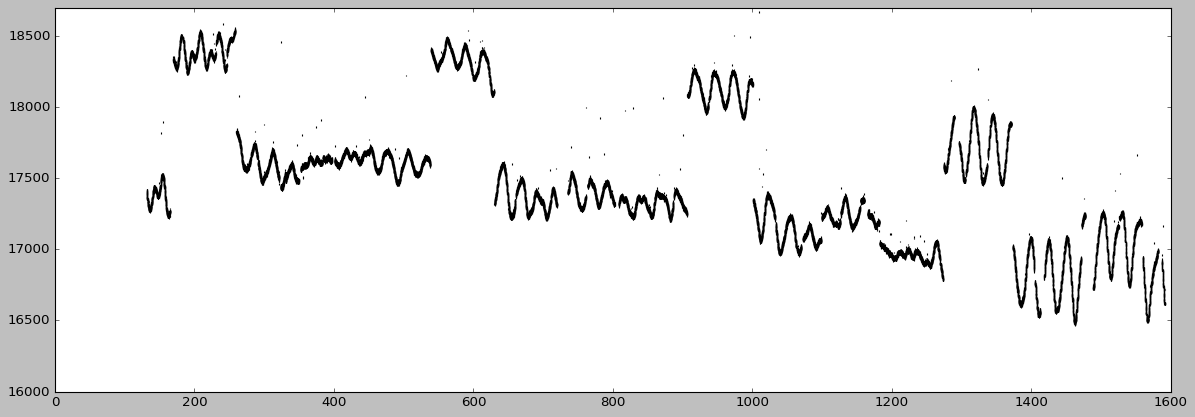

In [14]:
fig, ax = plt.subplots(1,1,figsize=(18,6))
ax.errorbar(alltime, allflux, yerr = allfluxerr, color='k', markersize=50, capsize=0, linestyle='None')
ax.set_ylim(16000,18700)
plt.show()

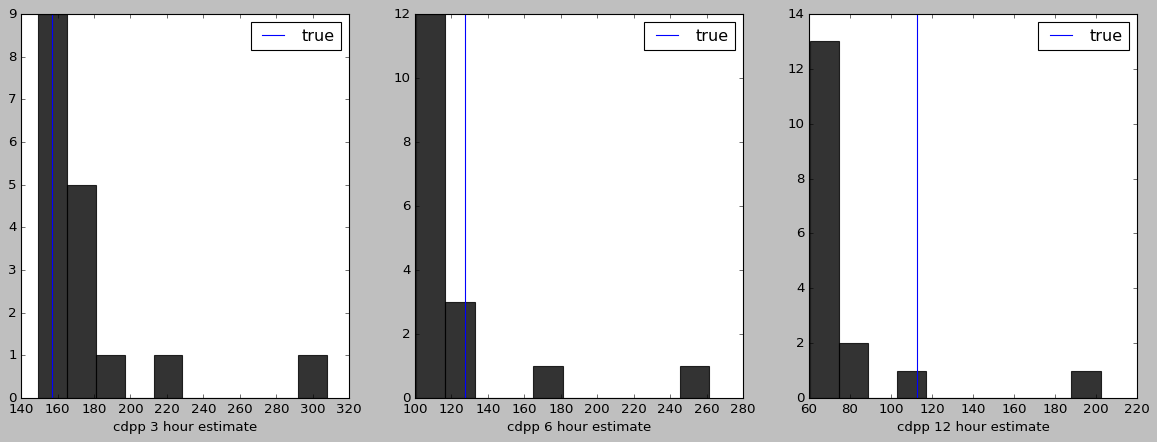

In [15]:
fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].hist(cdpp3est, color='k', alpha=0.8)
axes[0].axvline(kepStars['rrmscdpp03p0'][thisStarMask],label="true")
axes[1].hist(cdpp6est, color='k', alpha=0.8)
axes[1].axvline(kepStars['rrmscdpp06p0'][thisStarMask],label="true")
axes[2].hist(cdpp12est, color='k', alpha=0.8)
axes[2].axvline(kepStars['rrmscdpp12p0'][thisStarMask],label="true")

for ax in axes:
    ax.legend(loc="upper right")

axes[0].set_xlabel("cdpp 3 hour estimate")
axes[1].set_xlabel("cdpp 6 hour estimate")
axes[2].set_xlabel("cdpp 12 hour estimate")
plt.show()

In [16]:
2./(60.*24)

0.001388888888888889

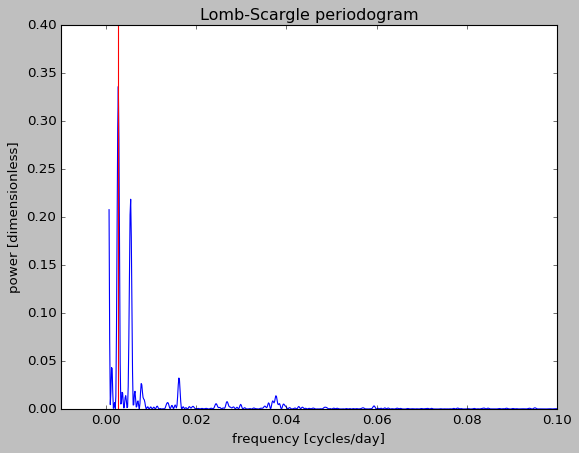

frequency of max power is 0.0027406853235496242 day^-1
corresponding period is 364.87224250350664 day


In [17]:
# LS periodogram of signal
frequency, power = LombScargle(alltime,allflux).autopower(minimum_frequency=(1./(np.max(alltime)-np.min(alltime))), maximum_frequency=(1./(2.*0.02083)))

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(frequency,power)
ax.set_xlabel('frequency [cycles/day]')
ax.set_ylabel('power [dimensionless]')
ax.set_title('Lomb-Scargle periodogram')
ax.axvline(frequency[np.argmax(power)],color='r')
ax.set_xlim(-0.01,0.1)
ax.set_ylim(0,0.4)
plt.show()

print("frequency of max power is {0} day^-1".format(frequency[np.argmax(power)])) #frequency of max power in this case is 1 year
print("corresponding period is {0} day".format(1./frequency[np.argmax(power)]))

In [18]:
# based on by-eye inspection of rotational modulation, look at periods ~20-35 days
frequencySlice = (frequency > 0.03) & (frequency < 0.04)
powerSlice = power[frequencySlice]
#print(powerSlice[np.argmax(powerSlice)])
print(frequency[frequencySlice][np.argmax(powerSlice)])

test_per = 1./frequency[frequencySlice][np.argmax(powerSlice)]
print(test_per)

0.03768442319880733
26.536163091164116


In [22]:
# Stitch quarters together and normalize by median of each quarter
for q in range(1,18):
    thisQ_mask = (allquarters == q)

    #normalize each q by median value
    thisQ_fluxmed = np.median(allflux[thisQ_mask])
    
    allflux[thisQ_mask] = allflux[thisQ_mask]/thisQ_fluxmed
    allfluxerr[thisQ_mask] = allfluxerr[thisQ_mask]/thisQ_fluxmed


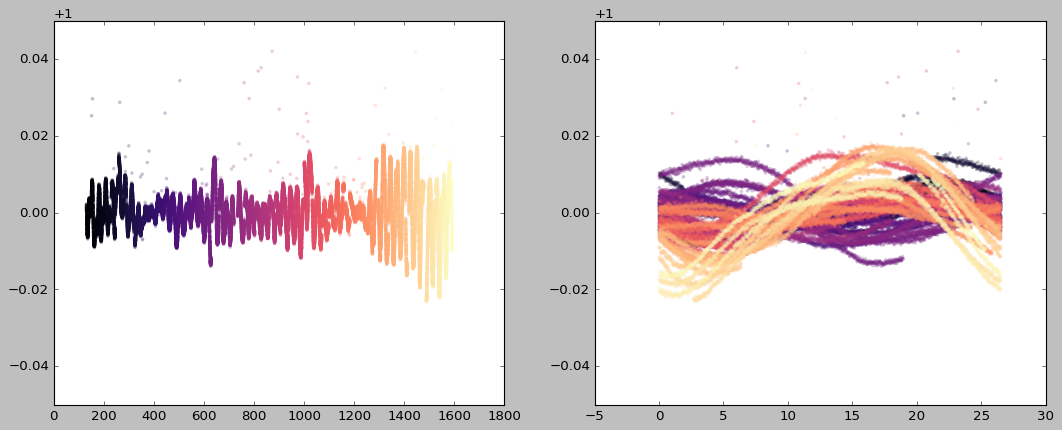

In [23]:
#phase fold the LC
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].scatter(alltime, allflux,c=alltime,s=10,cmap='magma',marker='o',edgecolor='None',linestyle='None',alpha=0.25)
axes[1].scatter(alltime%test_per, allflux,c=alltime,s=10,cmap='magma',marker='o',edgecolor='None',linestyle='None',alpha=0.25)
for ax in axes:
    ax.set_ylim(0.95,1.05)
plt.show()

#not great!! this one does evolve, unlike the SPECULOOS M-dwarf

In [24]:
tosave = np.vstack((alltime.T + 2454833., allflux.T, allfluxerr.T, allquarters.T)).T
print(np.shape(tosave))

(64887, 4)


In [26]:
# save data to file
np.savetxt("./kepler_style_G4.txt", tosave, fmt='%f %f %f %d', delimiter=" ", header="time[BJD] normflux normfluxerr quarter")